In [1]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [2]:
#回归问题评价指标
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
#分类问题评价指标
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss#对数损失（交叉熵损失）

In [3]:
data=pd.read_excel('FTIR.xlsx',index_col=0)
X=data.iloc[:,:-1].values
y=data.iloc[:,-1].values
columns=data.iloc[:,:-1].columns.values


In [4]:
# 将数据分为训练集、验证集和测试集
from sklearn.model_selection import train_test_split

# 第一次划分：70%训练集，30%为临时集（包含验证集和测试集）
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=123)

# 第二次划分：从临时集中划分出验证集和测试集（1:2的比例）
# 30% * (1/3) = 10% 验证集
# 30% * (2/3) = 20% 测试集
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=2/3, random_state=123)

# 打印各个数据集的形状
print('X_train.shape:', X_train.shape)
print('y_train.shape:', y_train.shape)
print('X_val.shape:', X_val.shape)
print('y_val.shape:', y_val.shape)
print('X_test.shape:', X_test.shape)
print('y_test.shape:', y_test.shape)

X_train.shape: (126, 3351)
y_train.shape: (126,)
X_val.shape: (18, 3351)
y_val.shape: (18,)
X_test.shape: (36, 3351)
y_test.shape: (36,)


In [5]:
#定义函数计算评价指标
def calculate_metrics_two(y_true,y_pred):#二分类
    accuracy=accuracy_score(y_true,y_pred)
    sensitivity=recall_score(y_true,y_pred)#敏感性（召回率）
    specificity=confusion_matrix(y_true,y_pred)[0,0]/(confusion_matrix(y_true,y_pred)[0,0]+confusion_matrix(y_true,y_pred)[0,1])
    positive_predictive_values=precision_score(y_true,y_pred)
    negative_predictive_value=confusion_matrix(y_true,y_pred)[1,1]/(confusion_matrix(y_true,y_pred)[1,1]+confusion_matrix(y_true,y_pred)[1,0])
    f1=f1_score(y_true,y_pred)
    kappa=cohen_kappa_score(y_true,y_pred)
    return [accuracy,sensitivity,specificity,positive_predictive_values,negative_predictive_value,f1,kappa]

def calculate_metrics_multi(y_true,y_pred):#多分类
    accuracy=accuracy_score(y_true,y_pred)
    precision=precision_score(y_true,y_pred,average='macro')
    recall=recall_score(y_true,y_pred,average='macro')
    f1=f1_score(y_true,y_pred,average='macro')
    kappa=cohen_kappa_score(y_true,y_pred)
    return [accuracy,precision,recall,f1,kappa]

In [6]:
# 创建随机森林分类器对象
rf = RandomForestClassifier(random_state=42)

# 定义超参数的分布
param_distributions = {
    "n_estimators": np.arange(10, 201, 10),
    "max_depth": [None] + list(np.arange(3, 14)),
    "min_samples_split": np.arange(2, 11),
    "min_samples_leaf": np.arange(1, 6),
    "max_features": ["auto", "sqrt", "log2", None] + list(np.arange(1, X_train.shape[1] + 1))
}

# 创建随机搜索对象
random_search = RandomizedSearchCV(rf, param_distributions, n_iter=10, cv=5, random_state=42)

random_search.fit(X_train,y_train)


#获取最佳参数
best_params=random_search.best_params_
print("随机搜索的最佳参数：",best_params)

best_model = random_search.best_estimator_
 
y_pred_train = best_model.predict(X_train) 
y_pred_val = best_model.predict(X_val)
y_pred_test = best_model.predict(X_test)

[accuracy_train,precision_train,recall_train,f1_train,kappa_train]=calculate_metrics_multi(y_pred_train,y_train) 
[accuracy_val,precision_val,recall_val,f1_val,kappa_val]=calculate_metrics_multi(y_pred_val,y_val)
[accuracy_test,precision_test,recall_test,f1_test,kappa_test]=calculate_metrics_multi(y_pred_test,y_test) 
print("训练集准确率",accuracy_train) 
print("训练集精确率",precision_train) 
print("训练集召回率：",recall_train) 
print("训练集F1分数：",f1_train) 
print("训练集Kappa系数：",kappa_train) 

print("验证集准确率：",accuracy_val)
print("验证集精确率",precision_val)
print("验证集召回率",recall_val)
print("验证集F1分数：",f1_val)
print("验证集Kappa系数：",kappa_val)

print("测试集准确率：",accuracy_test) 
print("测试集精确率",precision_test) 
print("测试集召回率",recall_test) 
print("测试集F1分数：",f1_test) 
print("测试集Kappa系数：",kappa_test)

随机搜索的最佳参数： {'n_estimators': 130, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 1371, 'max_depth': 6}
训练集准确率 0.9761904761904762
训练集精确率 0.975
训练集召回率： 0.9787234042553191
训练集F1分数： 0.9760239760239761
训练集Kappa系数： 0.9642180992048467
验证集准确率： 0.9444444444444444
验证集精确率 0.9583333333333334
验证集召回率 0.9583333333333334
验证集F1分数： 0.9555555555555556
验证集Kappa系数： 0.9113300492610837
测试集准确率： 0.9722222222222222
测试集精确率 0.9791666666666666
测试集召回率 0.9761904761904763
测试集F1分数： 0.9769016328156113
测试集Kappa系数： 0.9563636363636364


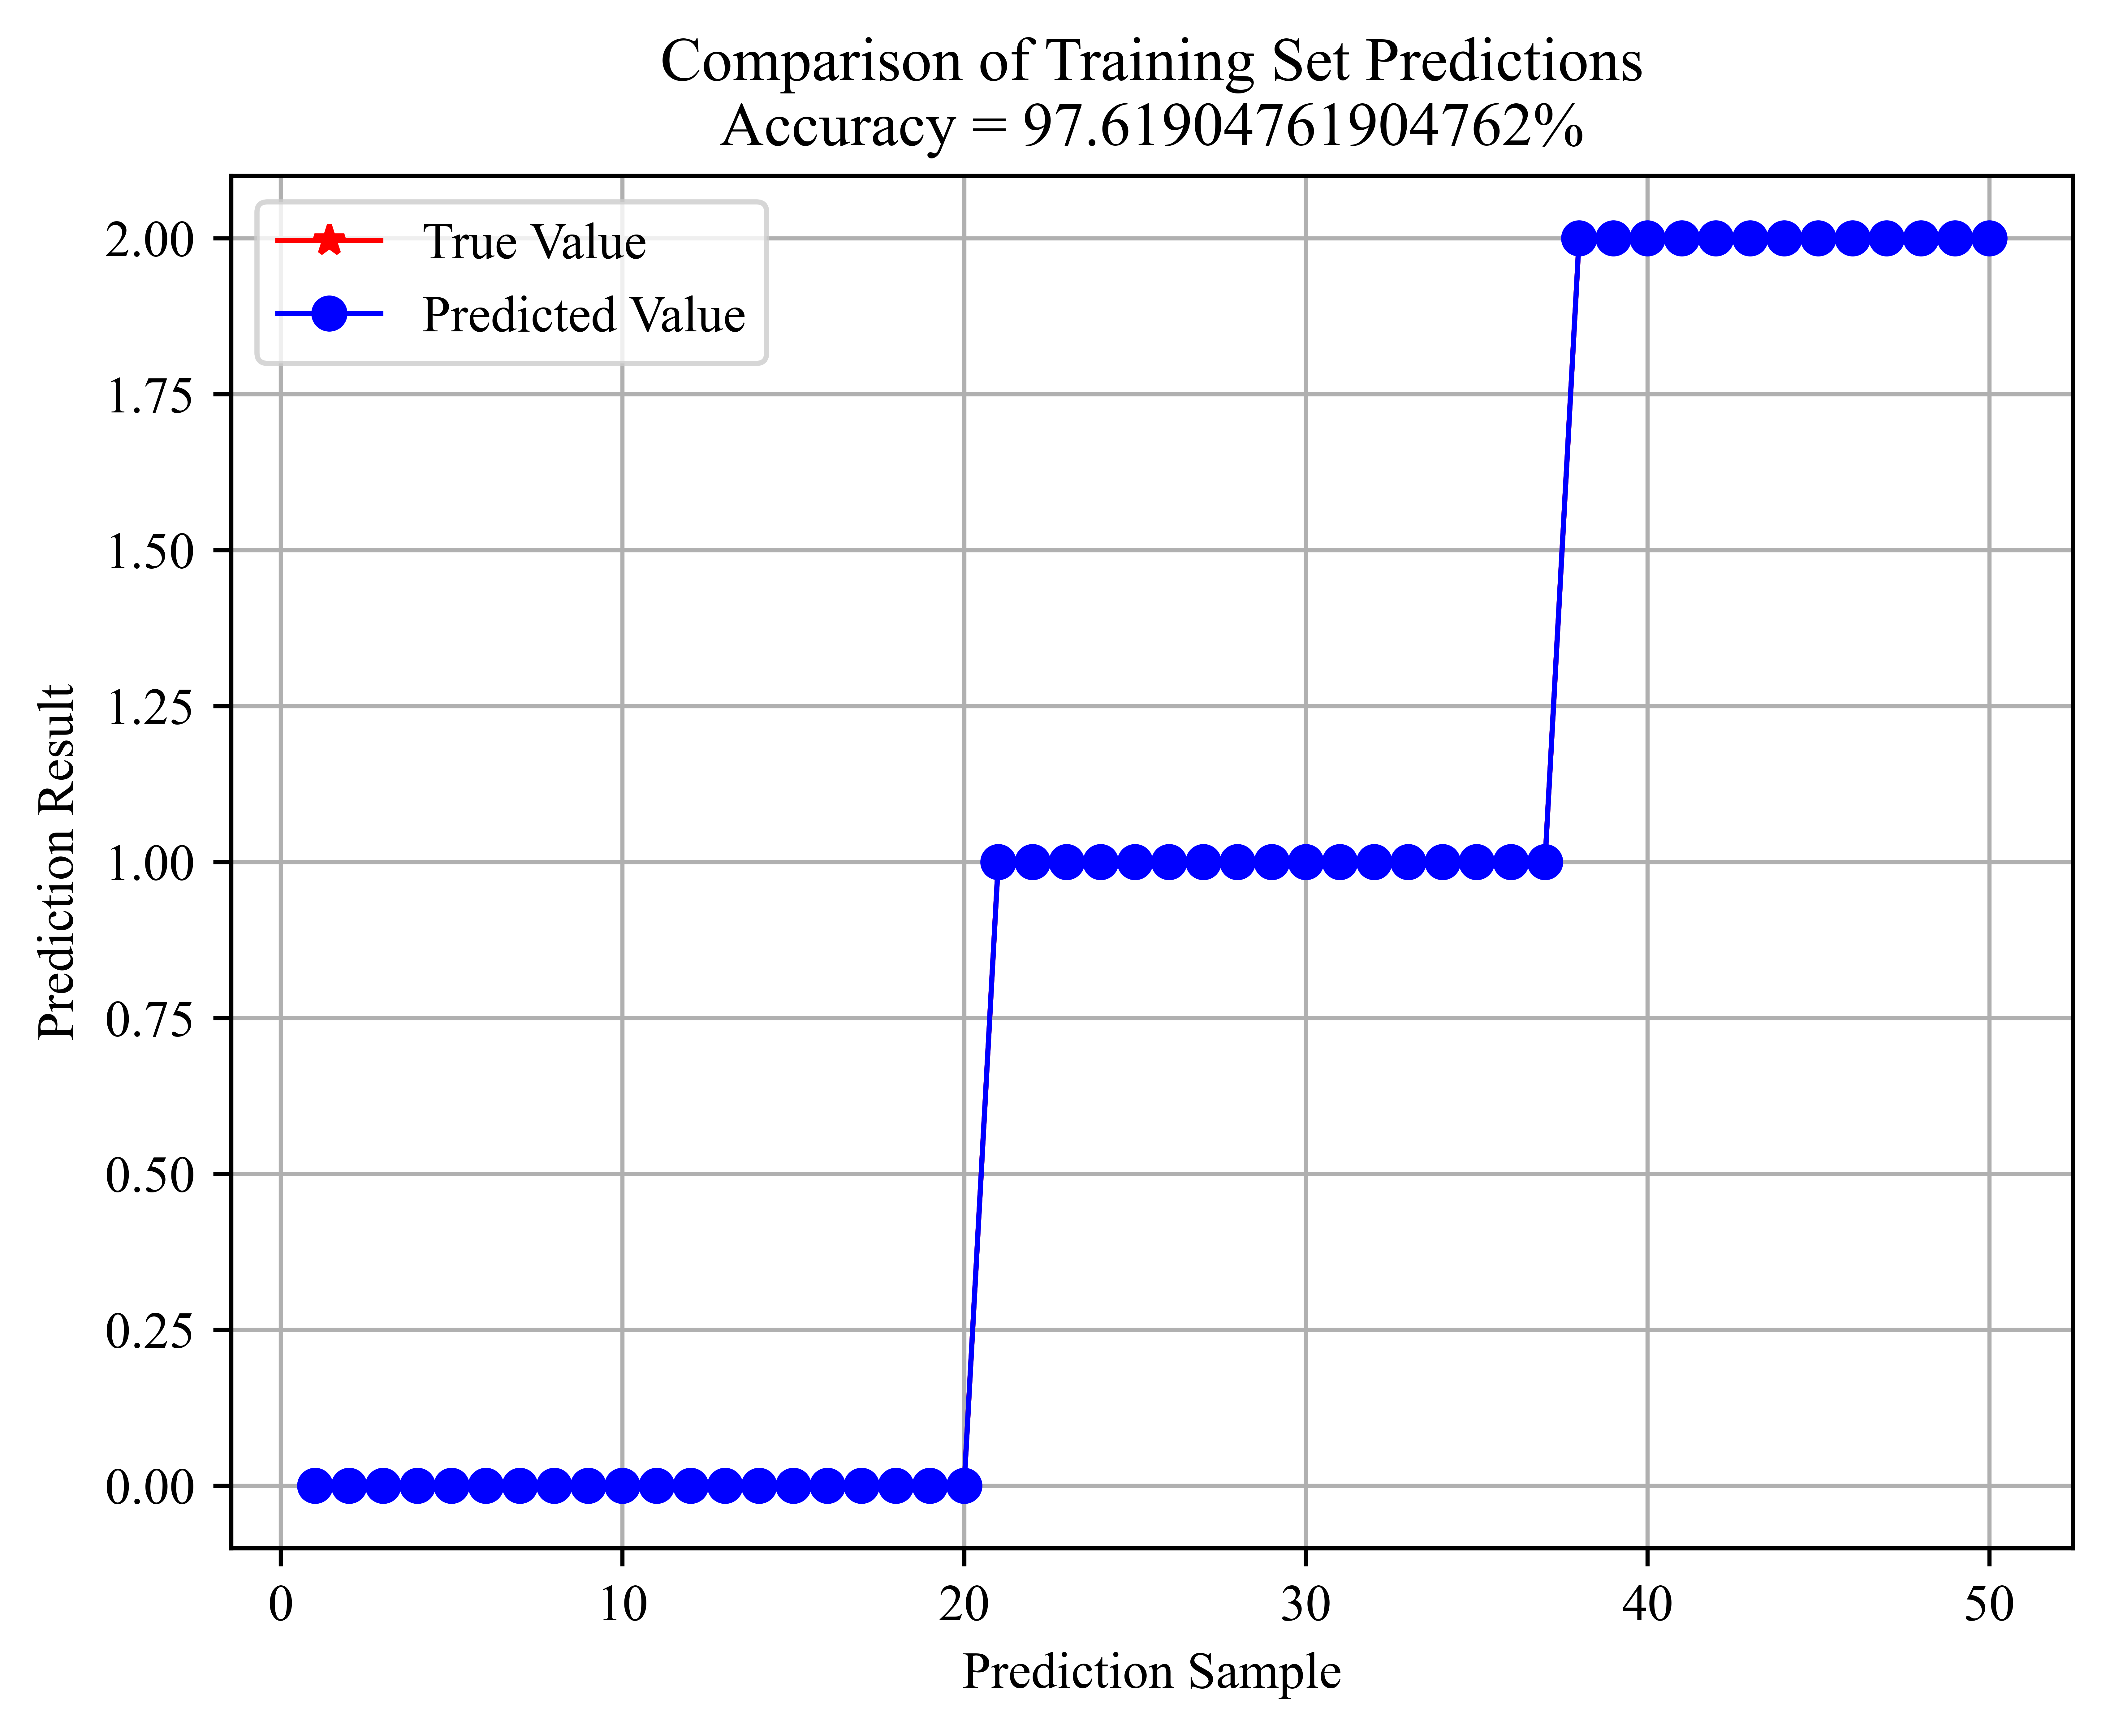

In [7]:
N = len(y_train)
index_50_train=np.random.choice(range(0, N), 50, replace=True)#随机挑选50个样本出来，样本太多不好显示
y_train_=y_train[index_50_train]
y_train_pred_=y_pred_train[index_50_train]

index_train = np.argsort(y_train_)
y_train_sort = np.sort(y_train_)

y_pred_train_sort = np.array(y_train_pred_)[index_train]

plt.figure( dpi=1200)

plt.rcParams["font.family"] = "Times New Roman"

# 绘制真实值曲线
plt.plot(np.arange(1, 50+1), y_train_sort, 'r-*', label='True Value', linewidth=1)

# 绘制预测值曲线
plt.plot(np.arange(1, 50+1), y_pred_train_sort, 'b-o', label='Predicted Value', linewidth=1)

# 添加图例
plt.legend()

# 设置x轴标签
plt.xlabel('Prediction Sample')

# 设置y轴标签
plt.ylabel('Prediction Result')

# 设置标题，将准确率信息添加到标题中
string = f"Comparison of Training Set Predictions\nAccuracy = {accuracy_train*100}%"
plt.title(string)

# 添加网格
plt.grid()

# 显示图形
plt.show()

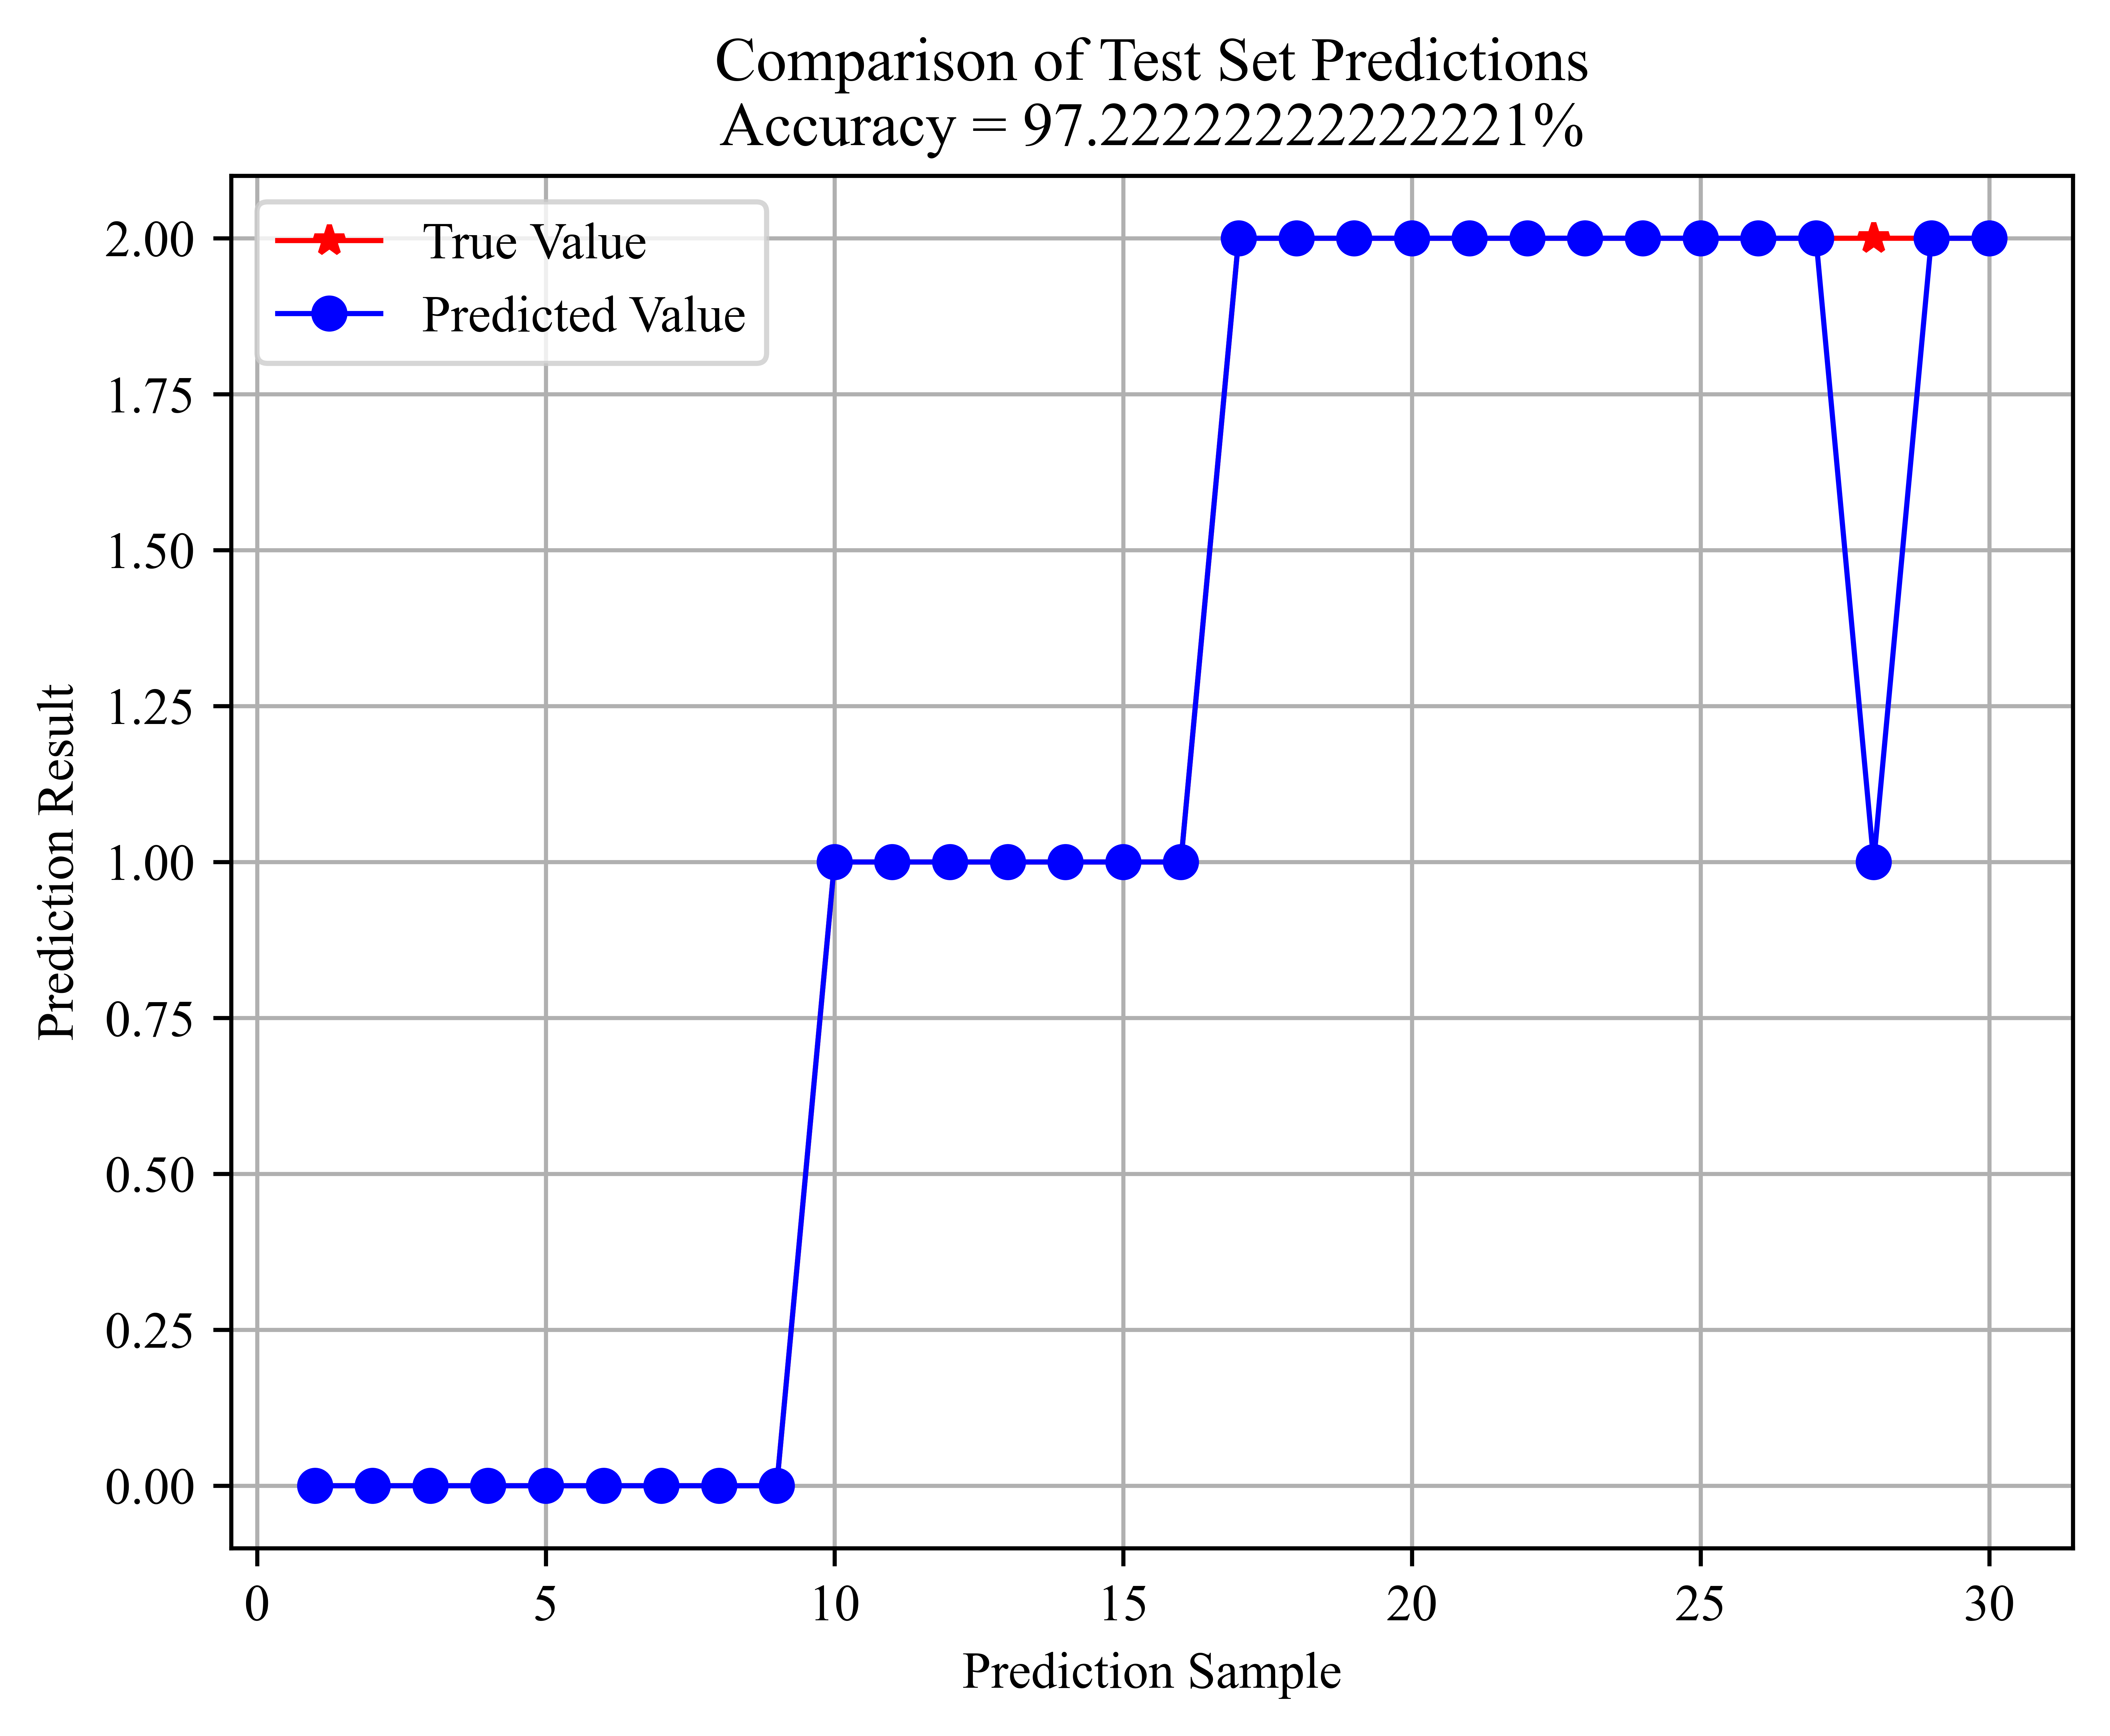

In [8]:
N = len(y_test)
index_30_test=np.random.choice(range(0, N), 30, replace=True)#随机挑选20个样本出来，样本太多不好显示
y_test_=y_test[index_30_test]
y_test_pred_=y_pred_test[index_30_test]

index_test= np.argsort(y_test_)
y_test_sort = np.sort(y_test_)

y_pred_test_sort = np.array(y_test_pred_)[index_test]

plt.figure( dpi=1200)

plt.rcParams["font.family"] = "Times New Roman"

# 绘制真实值曲线
plt.plot(np.arange(1, 30 + 1), y_test_sort, 'r-*', label='True Value', linewidth=1)

# 绘制预测值曲线
plt.plot(np.arange(1, 30 + 1), y_pred_test_sort, 'b-o', label='Predicted Value', linewidth=1)

# 添加图例
plt.legend()

# 设置x轴标签
plt.xlabel('Prediction Sample')

# 设置y轴标签
plt.ylabel('Prediction Result')

# 设置标题，将准确率信息添加到标题中
string = f"Comparison of Test Set Predictions\nAccuracy = {accuracy_test*100}%"
plt.title(string)

# 添加网格
plt.grid()

# 显示图形
plt.show()

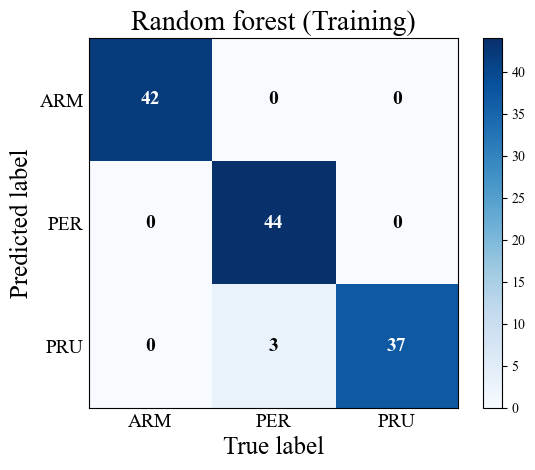

In [9]:
import scikitplot as skplt
mapping = { 0: 'ARM',   1: 'PER',2: 'PRU'} 

y_train_map= [mapping[i] if i in mapping else i for i in y_train] 
y_pred_train_map = [mapping[i] if i in mapping else i for i in np.array(y_pred_train)] 
plot = skplt.metrics.plot_confusion_matrix(y_train_map, y_pred_train_map)

plt.tick_params(axis='both', which='both', length=0)  
plt.title('Random forest (Training)', fontsize=20)
# 设置标题和轴标签，并修改字体大小
plt.xlabel("True label", fontsize=18)  # X轴标签字体大小
plt.ylabel("Predicted label", fontsize=18)  # Y轴标签字体大小
# 调整刻度标签的字体大小
plt.xticks(fontsize=14)  # X轴刻度标签字体大小
plt.yticks(fontsize=14)  # Y轴刻度标签字体大小
# 调整单元格内数字的字体大小
for text in plot.texts:
    text.set_fontsize(14)  
    text.set_fontweight("bold")  # 如果要加粗

plt.savefig('Random forest_TRAIN.png', dpi=1200, bbox_inches='tight') 
plt.show()

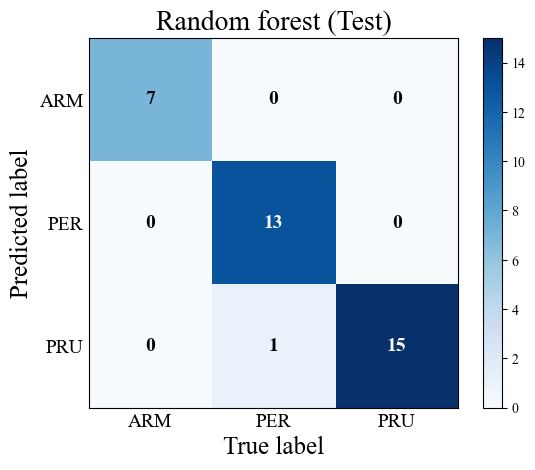

In [10]:
import scikitplot as skplt
mapping = {  0: 'ARM',   1: 'PER',2: 'PRU'} 

y_test_map= [mapping[i] if i in mapping else i for i in y_test] 
y_pred_test_map = [mapping[i] if i in mapping else i for i in np.array(y_pred_test)] 
plot = skplt.metrics.plot_confusion_matrix(y_test_map, y_pred_test_map)

plt.tick_params(axis='both', which='both', length=0)  
plt.title('Random forest (Test)', fontsize=20)
# 设置标题和轴标签，并修改字体大小
plt.xlabel("True label", fontsize=18)  # X轴标签字体大小
plt.ylabel("Predicted label", fontsize=18)  # Y轴标签字体大小
# 调整刻度标签的字体大小
plt.xticks(fontsize=14)  # X轴刻度标签字体大小
plt.yticks(fontsize=14)  # Y轴刻度标签字体大小
# 调整单元格内数字的字体大小
for text in plot.texts:
    text.set_fontsize(14)  
    text.set_fontweight("bold")  # 如果要加粗
plt.savefig('random forest_Test.png', dpi=800,bbox_inches='tight') 
plt.show()

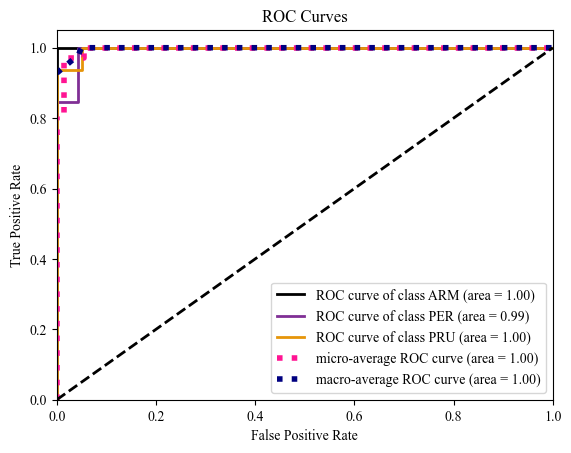

In [11]:
y_pred_proba=best_model.predict_proba(X_test)
#'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Grays', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_grey', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gist_yerg', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'grey', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'winter', 'winter_r'
skplt.metrics.plot_roc(y_test_map, y_pred_proba,cmap='CMRmap')
plt.savefig('random forest roc.png', dpi=800,bbox_inches='tight') 
plt.show()


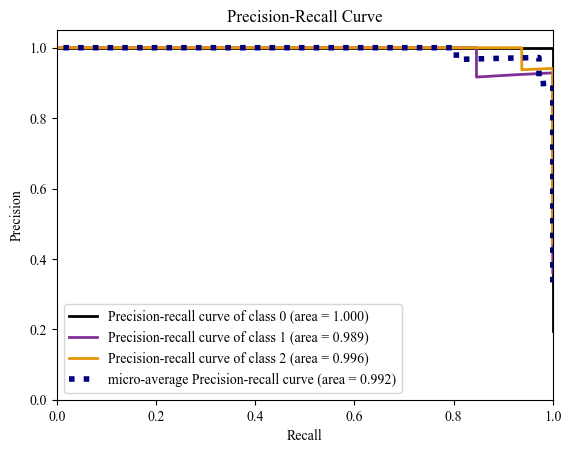

In [12]:
skplt.metrics.plot_precision_recall(y_test,y_pred_proba,cmap='CMRmap')
plt.savefig('random forest pr.png', dpi=800,bbox_inches='tight')
